#1.유튜브 댓글 분석

In [1]:
# -*- coding: utf-8 -*-
"""유튜브_댓글_분석_안성근.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1DhPGwp5xjkm3_QaQfZW_o1irN8XaSdbZ

# 텍스트 분석 라이브러리 초기화
"""
# Commented out IPython magic to ensure Python compatibility.
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
# 시각화 결과가 선명하게 표시
# %config InlineBackend.figure_fromat = 'retina'
# range 대신 처리 시간을 알려주는 라이브러리
from tqdm import trange


In [2]:
"""# 시각화를 위한 한글폰트 설정"""

# 윈도우 한글폰트 설정
plt.rc("font", family='Malgun Gothic')


## 1.1. 아티스트 이름


In [3]:
artist_name=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/[공유] Mulcam_Army 공유폴더!/아티스트이름 - Sheet1.csv')
name=artist_name['engName']
name.dropna(inplace=True)
name=name.reset_index()
name.drop(['index'],axis=1, inplace=True)
name[:4]

,engName
0,GOT7
1,GOLDEN CHILD
2,KIM SE JEONG
3,KIM JAEHWAN


In [4]:
name.drop([3,5,24,29,37,38,48],axis=0, inplace=True)
name=name.reset_index()
name.drop(['index'],axis=1, inplace=True)
name[:4]

,engName
0,GOT7
1,GOLDEN CHILD
2,KIM SE JEONG
3,NU_EST


# 2.전체 아이돌 분석

## 2.1. 유튜브 크롤링 댓글 불러오기

In [5]:
# 유튜브 크롤링 파일 로드
path = '/content/drive/MyDrive/Colab Notebooks/[공유] Mulcam_Army 공유폴더!/크롤링 한 자료/youtube/영상별 댓글/'

frames=[]
keys = []
for i in range(len(name['engName'])):
    temp=name['engName'][i]
    comment_file = f'comments_youtube_{temp}.csv'     #GOT7
    df = pd.read_csv(path+comment_file, encoding='utf-8', header=None)
    # print(df)
    # print('\n')
    frames.append(df)
    keys.append(temp)

df = pd.concat(frames, ignore_index=True)
df.columns=['comment','like']
# df.head()

##2.2. 중복 값 제거 및 소문자 바꾸기

In [6]:
"""# 네트워크 오류 등으로 발생한 중복 입력 값 제거
- 빈도 수 중복 방지
- 대문자 소문자로 바꾸기
"""

# 중복 값 제거
print('중복 제거 전 :',df.shape)
df = df.drop_duplicates(['comment'],keep='last',ignore_index=True)
print('중복 제거 후 :',df.shape)

# 소문자로 바꾸기
df['comment'] = df['comment'].str.lower()
# copy_data.to_csv('concat_txt.csv',encoding='utf-8-sig')
# df
df.to_csv('/content/drive/MyDrive/Colab Notebooks/[공유] Mulcam_Army 공유폴더!/comment_all.csv')

중복 제거 전 : (388755, 2)
중복 제거 후 : (211030, 2)


##2.3. 텍스트 전처리 (이모티콘, 특수문자, 의성어 제거)

In [7]:
"""# 텍스트 전처리 1차 작업"""

# 전처리 전 원본 보존
import copy
copy_data = copy.deepcopy(df)
copy_data.info()

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

#분석에 어긋나는 불용어구 제외 (특수문자, 의성어)
han = re.compile(r'[ㄱ-ㅎㅏ-ㅣ!?~,".\n\r#\ufeff\u200d]')

comment_result = []

for i in copy_data['comment'].values:
    tokens = re.sub(emoji_pattern,"",i)
    tokens = re.sub(han,"",tokens)
    comment_result.append(tokens)

# 이모티콘 의성어 제대로 안 없어 졌다.
# comment_result


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211030 entries, 0 to 211029
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   comment  211030 non-null  object
 1   like     211030 non-null  object
dtypes: object(2)
memory usage: 3.2+ MB


In [8]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

def clean_punc(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text.strip()

cleaned_corpus = []
for sent in comment_result:
    cleaned_corpus.append(clean_punc(sent, punct, punct_mapping))

cleaned_corpus[:5]


['wow nice songggg',
 'rumo a 1b',
 'jisoo xinh xuất sắt đẹp quá mấy chị iu ơi chúc mừng mấy chị',
 'this is wow music structure dance fashion color stunning revolutionary pop',
 'this song is really so good ktl had to grow on me but when i listened to this the first time  i immediately loved it the chorus and everything was so catchy']

In [9]:
def clean_text(texts):
    corpus = []
    for i in range(0, len(texts)):
        review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"]', '',str(texts[i])) #remove punctuation
        review = re.sub(r'\d+','', str(texts[i]))# remove number
        review = review.lower() #lower case
        review = re.sub(r'\s+', ' ', review) #remove extra space
        review = re.sub(r'<[^>]+>','',review) #remove Html tags
        review = re.sub(r'\s+', ' ', review) #remove spaces
        review = re.sub(r"^\s+", '', review) #remove space from start
        review = re.sub(r'\s+$', '', review) #remove space from the end
        corpus.append(review)
    return corpus

basic_preprocessed_corpus = clean_text(cleaned_corpus)
comment_result = pd.DataFrame(basic_preprocessed_corpus, columns=["comment"])
comment_result.head()

,comment
0,wow nice songggg
1,rumo a b
2,jisoo xinh xuất sắt đẹp quá mấy chị iu ơi chúc...
3,this is wow music structure dance fashion colo...
4,this song is really so good ktl had to grow on...


##2.4. fasttext 활용한 언어분류

영어, 한국어, 스페인어, 인도네시아어, 기타 언어로 구분

In [10]:
"""# 언어별 분류 작업
- 정확도가 높은 fasttext 모듈로 분류
"""
!pip install fasttext

In [11]:
import fasttext
model = fasttext.load_model('/content/drive/MyDrive/Colab Notebooks/[공유] Mulcam_Army 공유폴더!/lid.176.ftz')

predict = []
for t in comment_result.comment.values:
  predict.append(model.predict(t,k=1))

ty = pd.DataFrame(predict)

comment = []
for num, txt in enumerate(ty[0]):
  #print(txt)
  #if num == 30:
   # break
  
  txt = str(txt)

  if txt == "('__label__ko',)":
    b = re.sub(txt,"ko",txt)
    comment.append(b)
  elif txt == "('__label__en',)":
    b = re.sub(txt,"en",txt)
    comment.append(b)
  elif txt == "('__label__id',)":
    b = re.sub(txt,"id",txt)
    comment.append(b)
  elif txt == "('__label__es',)":
    b = re.sub(txt,"es",txt)
    comment.append(b)
  else:
    b = re.sub(txt,"etc",txt)
    comment.append(b)

comment = pd.DataFrame(comment)
comment.head()

,0
0,(en)
1,(etc)
2,(etc)
3,(en)
4,(en)


In [12]:
ty[0].value_counts()

(__label__en,)     141424
(__label__ko,)      21738
(__label__es,)      16751
(__label__id,)       4577
(__label__fr,)       3549
                    ...  
(__label__sah,)         1
(__label__mai,)         1
(__label__vls,)         1
(__label__mzn,)         1
(__label__frr,)         1
Name: 0, Length: 148, dtype: int64

In [13]:
comment.value_counts()

(en)     141424
(etc)     26540
(ko)      21738
(es)      16751
(id)       4577
dtype: int64

In [14]:
pd.set_option('max_columns',50)
pd.set_option('max_rows',100)
# ty_sum.to_csv('ty_sum.csv', encoding='cp949')

like = pd.DataFrame(copy_data['like'])
data = pd.concat([comment_result,like, comment],axis=1)
data.columns = ['comment','like','lang']
data.head()

,comment,like,lang
0,wow nice songggg,2,(en)
1,rumo a b,1,(etc)
2,jisoo xinh xuất sắt đẹp quá mấy chị iu ơi chúc...,263,(etc)
3,this is wow music structure dance fashion colo...,2,(en)
4,this song is really so good ktl had to grow on...,2,(en)


In [15]:
data_ko = pd.DataFrame([kor[:1] for kor in data.values if kor[2] == '(ko)'], columns=['comment'])
data_en = pd.DataFrame([en[:1] for en in data.values if en[2] == '(en)'], columns=['comment'])
# data_ko.comment.values

# 3.영어 댓글 분석

In [16]:
# 숫자제거 / 밑줄 제외한 특수문자 제거
p = re.compile("[0-9]+")
q = re.compile("\W+")
r = re.compile('[^a-zA-Z]+')

en = []
for i in data_en.comment.values:
  tokens = re.sub(p," ",i)
  tokens = re.sub(q," ",tokens)
  tokens = re.sub(r," ", tokens)
  en.append(tokens)
len(en)

141424

##3.1. 영어 불용어 제거


In [17]:
# 불용어 제거
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

In [18]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [19]:
stop_words = set(stopwords.words('english')) 
res=[]
for i in range(len(en)):
    word_tokens = word_tokenize(en[i])

    result = []
    for w in word_tokens: 
        if w not in stop_words: 
            result.append(w) 
    res.append(result)

# print(word_tokens) 
print(res[:2])
print(len(res))

[['wow', 'nice', 'songggg'], ['wow', 'music', 'structure', 'dance', 'fashion', 'color', 'stunning', 'revolutionary', 'pop']]
141424


##3.2. 영어 형태소 분석 / 품사 태깅


In [20]:
en_pos = []
for i in range(len(res)):
    tokens_pos = nltk.pos_tag(res[i])
    en_pos.append(tokens_pos)
en_pos[:2]

[[('wow', 'JJ'), ('nice', 'JJ'), ('songggg', 'NN')],
 [('wow', 'JJ'),
  ('music', 'NN'),
  ('structure', 'NN'),
  ('dance', 'NN'),
  ('fashion', 'NN'),
  ('color', 'NN'),
  ('stunning', 'VBG'),
  ('revolutionary', 'JJ'),
  ('pop', 'NN')]]

In [21]:
# 명사는 NN을 포함하고 있음을 알 수 있음
en_NN=[]
for i in range(len(en_pos)):
    NN_words = []
    for word, pos in en_pos[i]:
        if 'NN' in pos:
            NN_words.append(word)
    en_NN.extend(NN_words)
en_NN[:2]

['songggg', 'music']

##3.3. 단어(명사) 빈도 분석


In [22]:
#9. 빈도분석
from collections import Counter
c = Counter(en_NN) # input type should be a list of words (or tokens)
k = 10
print(c.most_common(k)) # 빈도수 기준 상위 k개 단어 출력

[('song', 11207), ('love', 4694), ('group', 4057), ('girls', 3624), ('youtube', 3609), ('views', 3574), ('time', 3523), ('mv', 3507), ('songs', 3209), ('music', 3009)]


##3.4. wordcloud 생성

In [23]:
#wordclound
import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

noun_text = ''
for word in en_NN:
    noun_text = noun_text +' '+word


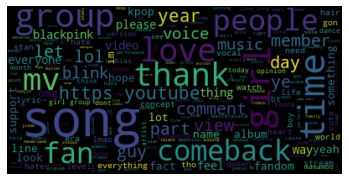

In [24]:
wordcloud = WordCloud(max_font_size=60, relative_scaling=.5).generate(noun_text) # generate() 는 하나의 string value를 입력 받음
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('/content/drive/MyDrive/Colab Notebooks/[공유] Mulcam_Army 공유폴더!/wordcloud.png')

##3.5. 영어 토픽 모델링

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize


### 3.5.1. 전처리 (길이 3이하 짧은 단어 제거)

In [26]:
## 3단어 이하 짧은 단어 제거
 # remove words less than three letters
# print(res[1])
# for word in res[1]:
#     print(word)
en_sent_less3=[]
for i in range(len(res)):
    tokens = [word for word in res[i] if len(word) >= 3]
    en_sent_less3.append(tokens)
en_sent_less3[:2]


[['wow', 'nice', 'songggg'],
 ['wow',
  'music',
  'structure',
  'dance',
  'fashion',
  'color',
  'stunning',
  'revolutionary',
  'pop']]

In [27]:
en_sent =[]
for i in range(len(en_sent_less3)):
    temp=" ".join(en_sent_less3[i])
    en_sent.append(temp)
en_sent[:15]

['wow nice songggg',
 'wow music structure dance fashion color stunning revolutionary pop',
 'song really good ktl grow listened first time immediately loved chorus everything catchy',
 'phuong xox',
 'jennytthao emoji freeze views youtube check view real freeze',
 'jennytthao unless comment emojis',
 'delete emojis',
 'blackpink lisa emojis dont remove stop views comment emojis youtube consider spam',
 'ameiiiiiiii musica viciante parabens blackpink',
 'aaaa amei essa nova musicaaaaablink forever aaaaaaaaa like',
 'totally bop',
 'park chaeyoung jjangkim jisoo jjanglalisa manoban jjangkim jennie jjang',
 'blackpink standard queens',
 'lalisa manoban kim jennie kim jisoopark chaeyoung',
 'please dont use emojs freeze get lost process could please delete comment recomment without sure girls would still aprecciate would fandom feel free use instead anything likingthank']

### 3.5.2. 벡터화

In [28]:
"""# 빈도수 계산을 위한 텍스트 데이터 벡터화
 - BoW 단어를 특성 벡터로 변환
 - TF-IDF 를 사용하여 단어 적합성 평가
"""

# BoW 모델로 벡터화
count = CountVectorizer(ngram_range=(3,6),
                        max_df = .1,
                        max_features=5000, stop_words=None)
docs = en_sent
bag = count.fit_transform(docs)

In [29]:
# TF_IDF 벡터화

tfidf = TfidfVectorizer(ngram_range=(3,6), # 유니그램 바이그램으로 사용
                        min_df = 3, # 3회 미만으로 등장하는 토큰은 무시
                        max_df =0.95 # 많이 등장한 단어 5%의 토큰도 무시
                        )
docs_tf = tfidf.fit_transform(docs)

###3.5.3. 토픽모델링

In [30]:
"""# 잠재 디리클레 할당을 사용한 토픽 모델링"""

# LDA 사용 (BoW 기반)
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components = 10,
                                random_state = 1,
                                learning_method = 'batch')

X_topics = lda.fit_transform(bag)

In [31]:
# 결과 분석을 위해 각 토픽 당 중요 단어 10개 출력 (BoW 기반)
n_top_word = 10
feature_name = count.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
  print("토픽 %d:" % (topic_idx+1))
  print([feature_name[i] for i in topic.argsort()[:-n_top_word - 1: -1]])

토픽 1:
['lovesick girls believe', 'like lovesick girls', 'like lovesick girls believe', 'soojin deserves better', 'queendom dance practice', 'light nightclose meyou', 'one literally one', 'first time watching', 'blackpink lovesick girls', 'dance practice video']
토픽 2:
['nothing wrong falling', 'wrong falling love', 'nothing wrong falling love', 'world know everything', 'stop world know', 'know everything gay', 'stop world know everything', 'still looking love', 'world know everything gay', 'stop world know everything gay']
토픽 3:
['https wwwyoutubecom watchv', 'soojin deserved better', 'hail queen jennie', 'better soojin deserved', 'deserved better soojin', 'deserved better soojin deserved', 'love song much', 'soojin deserved better soojin', 'soojin deserved better soojin deserved', 'better soojin deserved better']
토픽 4:
['hey hey hey', 'shine light nightclose', 'deny lose lose', 'close perfect hurts throw', 'perfect hurts throw', 'close perfect hurts', 'inspiration mom said', 'blackpink

In [32]:
# LDA 사용 (tf-idf 기반)
lda_tfidf = LatentDirichletAllocation(n_components = 10,
                                      random_state = 1,
                                      learning_method = 'batch')

X_topics = lda_tfidf.fit_transform(docs_tf)

In [33]:
# 결과 분석을 위해 각 토픽 당 중요 단어 10개 출력 (tf-idf 기반)
n_top_word = 10
feature_name = count.get_feature_names()
for topic_idx, topic in enumerate(lda_tfidf.components_):
  print("토픽 %d:" % (topic_idx+1))
  print([feature_name[i] for i in topic.argsort()[:-n_top_word - 1: -1]])

토픽 1:


IndexError: ignored

#4.한글 댓글 분석

##4.1. 띄어쓰기 교정 안한 버전


In [34]:
"""# 텍스트 전처리 2차 작업"""
# !proper installation of python3
# !proper installation of pip

# !pip install tensorflow
# !pip install keras
!pip install git+https://github.com/ssut/py-hanspell.git

  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-oquddefm
  Running command git clone -q https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-oquddefm


In [35]:
'''!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=1RNYpLE-xbMCGtiEHIoNsCmfcyJP3kLYn" > /dev/null
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1RNYpLE-xbMCGtiEHIoNsCmfcyJP3kLYn" -o confused_loanwords.txt
'''

'''lownword_map = {}
lownword_data = open('/content/confused_loanwords.txt', 'r', encoding='utf-8')

lines = lownword_data.readlines()

for line in lines:
    line = line.strip()
    miss_spell = line.split('\t')[0]
    ori_word = line.split('\t')[1]
    lownword_map[miss_spell] = ori_word'''

'''# 스펠링 및 띄어쓰기 검사
from hanspell import spell_checker
from soynlp.normalizer import *

# 테스트
sent = "대체 왜 않돼는지 설명을 해바"
spelled_sent = spell_checker.check(sent)
checked_sent = spelled_sent.checked
 
print(checked_sent)

print(repeat_normalize('와하하하하하하하하하핫', num_repeats=2))'''

'''def spell_check_text(texts):
    
  corpus = []
  for sent in texts:

    sent = str(sent)
    spelled_sent = spell_checker.check(sent)
    checked_sent = spelled_sent.checked
    normalized_sent = repeat_normalize(checked_sent)

#    for lownword in lownword_map:
#      normalized_sent = normalized_sent.replace(lownword, lownword_map[lownword])
    corpus.append(normalized_sent)
  return corpus

'''

# 에러 이유를 모르겠다
''' spell_preprocessed_corpus = spell_check_text(a)

 File "<string>", line unknown
ParseError: not well-formed (invalid token): line 1, column 192 '''


' spell_preprocessed_corpus = spell_check_text(a)\n\n File "<string>", line unknown\nParseError: not well-formed (invalid token): line 1, column 192 '

In [36]:
# 숫자제거 / 밑줄 제외한 특수문자 제거
p = re.compile("[0-9]+")
q = re.compile("\W+")
r = re.compile('[^ ㄱ-ㅣ가-힣]+')

kr = []
for i in data_ko.comment.values:
  tokens = re.sub(p," ",i)
  tokens = re.sub(q," ",tokens)
  tokens = re.sub(r," ", tokens)
  kr.append(tokens)
kr[:2]

['와 진짜 목소리 대박인데근데 양손은 서로 가위바위보하는 건가요',
 '정말 많이 들었구나아이유 노래는 디테일들이 엄청많고 정교해서커버곡내도 느낌을 내는게 어려운데정말 많이 노력하신게 느껴지네요 최고다 김세정']

In [37]:
"""# soynlp를 이용한 토크나이즈 만들기"""
# SOYNLP 다운로드
!pip install soynlp

In [38]:
import urllib.request
from soynlp.utils import DoublespaceLineCorpus
from soynlp.noun import LRNounExtractor_v2
from soynlp.word import WordExtractor
from soynlp.tokenizer import LTokenizer

In [39]:
noun_extractor = LRNounExtractor_v2(verbose=True)
nouns = noun_extractor.train_extract(kr,min_noun_score=0.3, min_noun_frequency=5)

[Noun Extractor] use default predictors
[Noun Extractor] num features: pos=3929, neg=2321, common=107
[Noun Extractor] counting eojeols
[EojeolCounter] n eojeol = 67218 from 21738 sents. mem=1.640 Gb                    
[Noun Extractor] complete eojeol counter -> lr graph
[Noun Extractor] has been trained. #eojeols=197809, mem=1.700 Gb
[Noun Extractor] batch prediction was completed for 18933 words
[Noun Extractor] checked compounds. discovered 5433 compounds
[Noun Extractor] postprocessing detaching_features : 2724 -> 2699
[Noun Extractor] postprocessing ignore_features : 2699 -> 2607
[Noun Extractor] postprocessing ignore_NJ : 2607 -> 2577
[Noun Extractor] 2577 nouns (5433 compounds) with min frequency=5
[Noun Extractor] flushing was done. mem=1.723 Gb                    
[Noun Extractor] 51.28 % eojeols are covered


In [40]:
nouns['아이돌']

NounScore(frequency=260, score=0.9803921568627451)

In [41]:
list(noun_extractor._compounds_components.items())[:10]

[('아아아아아아아아아아', ('아아아아아아', '아아아아')),
 ('모르겠다라이브가미', ('모르겠다', '라이브', '가미')),
 ('너무너무너무너무너무', ('너무', '너무', '너무', '너무', '너무')),
 ('너무아름다운다운', ('너무', '아름', '다운', '다운')),
 ('리얼재연사계한사계후', ('리얼', '재연', '사계한', '사계후')),
 ('드립맛집문특댓글', ('드립', '맛집', '문특', '댓글')),
 ('미국하이틴재질', ('미국', '하이틴', '재질')),
 ('아름다운다운다운', ('아름', '다운', '다운', '다운')),
 ('블랙아이드필승이라고', ('블랙아이드필승', '이라고')),
 ('머리스타일바뀔때', ('머리', '스타일', '바뀔때'))]

In [42]:
noun_extractor.lrgraph.get_r('샤이니', topk=20)

[('', 327),
 ('는', 48),
 ('가', 36),
 ('편', 20),
 ('의', 17),
 ('를', 10),
 ('랑', 10),
 ('도', 8),
 ('와', 6),
 ('스러움이', 6),
 ('에', 6),
 ('스러움의', 6),
 ('스러운', 5),
 ('만', 5),
 ('스러움', 3),
 ('편은', 3),
 ('편이', 3),
 ('즈백', 2),
 ('한테', 2),
 ('에게', 2)]

### Word Extraction


품사 판별 (Part of speech tagging)은 주어진 문장에 대하여 단어를 인식하고 각 단어의 품사를 판별하는 과정입니다. KoNLPy는 여러 종류의 품사 판별기를 파이썬 환경에서 이용할 수 있도록 도와줍니다.

품사 판별기는 주로 말뭉치라 불리는 학습데이터를 기반으로 문장/어절의 패턴을 학습합니다.

[('아이오아이', '명사'), ('가', '조사'), ('5', '숫자'), ('년', '명사'), ...]

위와 같이 단어 별로 품사가 적혀있는 데이터를 학습에 이용합니다. 이와 같이 학습용 데이터를 이용하는 방법을 supervised learning이라 합니다. 하지만, supervised learning 기반 품사 판별기가 가지는 위험 중 하나는 모르는 단어가 등장했을 때 이를 처리하는 방법입니다. '아이오아이' 분명 단어임에도 학습 때 본 적이 없다면 단어로 인식되지 않을 수 있습니다.

또 다른 위험 중 하나는 도메인의 특별한 어구들을 알 수 없다는 겁니다. '끝까지간다'는 배우 이선균이 출연한 영화 제목 입니다. 데이터 분석의 입장에서는 '끝까지간다'를 문장이 아닌 단어로 보는 것이 더 적합합니다. 만약 영화리뷰를 분석하고 있다면 '끝까지간다'라는 단어가 여러 번 등장할 것이고, 우리는 리뷰들에 있는 이 단어에 여러번 노출되어 단어로 인식할 것입니다. 하지만 품사 판별기의 목적은 주어진 문장/어절을 알고 있는 단어들로 분해하여 인식하는 것이기 때문에 이를 하나의 단어로 인식하지 않습니다. 목적이 다르죠.


그래서 주어진 문서 집합에서 패턴을 찾아내어 단어를 추출해보려 합니다. 다른 학습데이터는 이용하지 않으며, 통계에 기반하여 단어를 찾아내는 unsupervised learning 방법입니다. 통계 기반으로 단어를 추출하는 방법은 여러가지가 있습니다. 그 중 3가지 방법을 구현해 두었습니다.

In [43]:
# Word Extraction

word_extractor = WordExtractor(min_frequency=5,
    min_cohesion_forward=0.05, 
    min_right_branching_entropy=0.001
)
word_extractor.train(kr) # list of str or like
words = word_extractor.extract()
len(words)

training was done. used memory 1.787 Gb
all cohesion probabilities was computed. # words = 15588
all branching entropies was computed # words = 20586
all accessor variety was computed # words = 20586


3112

In [44]:
words['샤이니']

Scores(cohesion_forward=0.9398979049603626, cohesion_backward=0.08642716314028859, left_branching_entropy=3.8782821893880173, right_branching_entropy=3.9239078986883, left_accessor_variety=73, right_accessor_variety=82, leftside_frequency=591, rightside_frequency=16)

WordExtractor가 계산하는 것은 다양한 종류의 단어 가능 점수들입니다. 이를 잘 조합하여 원하는 점수를 만들 수도 있습니다. 즐겨쓰는 방법 중 하나는 cohesion_forward에 right_branching_entropy를 곱하는 것으로, (1) 주어진 글자가 유기적으로 연결되어 함께 자주 나타나고, (2) 그 단어의 우측에 다양한 조사, 어미, 혹은 다른 단어가 등장하여 단어의 우측의 branching entropy가 높다는 의미입니다.

In [45]:
import math

def word_score(score):
    return (score.cohesion_forward * math.exp(score.right_branching_entropy))

print('단어   (빈도수, cohesion, branching entropy)\n')
for word, score in sorted(words.items(), key=lambda x:word_score(x[1]), reverse=True)[:30]:
    print('%s     (%d, %.3f, %.3f)' % (
            word, 
            score.leftside_frequency, 
            score.cohesion_forward,
            score.right_branching_entropy
            )
         )

단어   (빈도수, cohesion, branching entropy)

진짜     (3226, 0.866, 4.862)
합니다     (44, 0.681, 4.451)
노래     (2637, 0.886, 4.074)
샤이니     (591, 0.940, 3.924)
근데     (395, 0.914, 3.742)
까지     (34, 0.382, 4.505)
뮤비     (669, 0.893, 3.487)
너무     (2778, 0.905, 3.466)
감사합니다     (267, 0.733, 3.657)
항상     (200, 0.948, 3.382)
계속     (432, 0.719, 3.654)
내가     (494, 0.479, 4.035)
투피엠     (286, 0.834, 3.429)
역시     (259, 0.583, 3.755)
영상     (456, 0.579, 3.644)
댓글     (461, 0.907, 3.171)
정말     (464, 0.443, 3.887)
머리     (233, 0.685, 3.445)
우리집     (671, 0.597, 3.565)
했는데     (106, 0.537, 3.662)
뭔가     (218, 0.701, 3.395)
앨범     (188, 0.917, 3.123)
많이     (412, 0.463, 3.768)
으로     (18, 0.159, 4.804)
목소리     (307, 0.896, 3.016)
이렇게     (451, 0.284, 4.139)
준호     (420, 0.534, 3.478)
사랑해     (604, 0.524, 3.496)
입니다     (70, 0.375, 3.808)
컴백     (425, 0.728, 3.138)


Cohesion score, Branching Entropy, Accessor Variety 에 대하여 각각의 점수만 이용하고 싶은 경우에는 다음의 함수를 이용합니다.

In [46]:
cohesion_scores = word_extractor.all_cohesion_scores()
cohesion_scores['샤이니'] # (cohesion_forward, cohesion_backward)

all cohesion probabilities was computed. # words = 15588


(0.9398979049603626, 0.08642716314028859)

In [47]:
branching_entropy = word_extractor.all_branching_entropy()
branching_entropy['샤이니'] # (left_branching_entropy, right_branching_entropy)

all branching entropies was computed # words = 20586


(3.8782821893880173, 3.9239078986883)

In [48]:
accessor_variety = word_extractor.all_accessor_variety()
accessor_variety['샤이니'] # (left_accessor_variety, right_accessor_variety)

all accessor variety was computed # words = 20586


(73, 82)

In [49]:
'''
# # 예제 말뭉치 다운로드
# urllib.request.urlretrieve("https://raw.githubusercontent.com/lovit/soynlp/master/tutorials/2016-10-20.txt", filename="2016-10-20.txt")
# corpus = DoublespaceLineCorpus("2016-10-20.txt")
# len(corpus)

# # 예제 말뭉치 상위 5개 문서 텍스트 확인
# i = 0
# for document in corpus:
#   if len(document) > 0:
#     print(document)
#     i = i+1
#   if i == 5:
#     break

# # 예제 말뭉치 테스트
# word_extractor = WordExtractor()
# word_extractor.train(kr)
# word_score_table = word_extractor.extract()
# word_score_table["샤이"].cohesion_forward


# # 단어 워드클라우드 시각화 (불용어 제거 단어 선정을 위한)
# from wordcloud import WordCloud
# default_path = '/content/drive/MyDrive/[공유] Mulcam_Army 공유폴더!/'
# cloud = WordCloud(font_path=default_path+'NanumGothic.ttf').generate(corpus)
# plt.figure(figsize=(20,15))
# plt.imshow(cloud)
# plt.axis('off')
'''

'\n# # 예제 말뭉치 다운로드\n# urllib.request.urlretrieve("https://raw.githubusercontent.com/lovit/soynlp/master/tutorials/2016-10-20.txt", filename="2016-10-20.txt")\n# corpus = DoublespaceLineCorpus("2016-10-20.txt")\n# len(corpus)\n\n# # 예제 말뭉치 상위 5개 문서 텍스트 확인\n# i = 0\n# for document in corpus:\n#   if len(document) > 0:\n#     print(document)\n#     i = i+1\n#   if i == 5:\n#     break\n\n# # 예제 말뭉치 테스트\n# word_extractor = WordExtractor()\n# word_extractor.train(kr)\n# word_score_table = word_extractor.extract()\n# word_score_table["샤이"].cohesion_forward\n\n\n# # 단어 워드클라우드 시각화 (불용어 제거 단어 선정을 위한)\n# from wordcloud import WordCloud\n# default_path = \'/content/drive/MyDrive/[공유] Mulcam_Army 공유폴더!/\'\n# cloud = WordCloud(font_path=default_path+\'NanumGothic.ttf\').generate(corpus)\n# plt.figure(figsize=(20,15))\n# plt.imshow(cloud)\n# plt.axis(\'off\')\n'

In [50]:
# 단어 토크나이징
noun_extractor = LRNounExtractor_v2(verbose=True)

# 말뭉치는 리스트값으로 입력(명사만 추출)
nouns = noun_extractor.train_extract(kr)

word_extractor = WordExtractor(min_frequency=5,
                               min_cohesion_forward=0.05,
                               min_right_branching_entropy=0.001)
word_extractor.train(kr)


[Noun Extractor] use default predictors
[Noun Extractor] num features: pos=3929, neg=2321, common=107
[Noun Extractor] counting eojeols
[EojeolCounter] n eojeol = 67218 from 21738 sents. mem=1.751 Gb                    
[Noun Extractor] complete eojeol counter -> lr graph
[Noun Extractor] has been trained. #eojeols=197809, mem=1.751 Gb
[Noun Extractor] batch prediction was completed for 18933 words
[Noun Extractor] checked compounds. discovered 5433 compounds
[Noun Extractor] postprocessing detaching_features : 10340 -> 8745
[Noun Extractor] postprocessing ignore_features : 8745 -> 8611
[Noun Extractor] postprocessing ignore_NJ : 8611 -> 8478
[Noun Extractor] 8478 nouns (5433 compounds) with min frequency=1
[Noun Extractor] flushing was done. mem=1.774 Gb                    
[Noun Extractor] 55.78 % eojeols are covered
training was done. used memory 1.797 Gb


In [51]:
# 명사, 단어 확률값만 활용하여 토크나이저 만들기
cohesion_score = {word:score.cohesion_forward for word, score in words.items()}

noun_scores = {noun:score.score for noun, score in nouns.items()}
combined_scores = {noun:score + cohesion_score.get(noun, 0)
    for noun, score in noun_scores.items()}
combined_scores.update(
    {subword:cohesion for subword, cohesion in cohesion_score.items()
    if not (subword in combined_scores)}
)

tokenizer = LTokenizer(scores=combined_scores)

print(kr[0])
print(tokenizer.tokenize(kr[0]))

와 진짜 목소리 대박인데근데 양손은 서로 가위바위보하는 건가요
['와', '진짜', '목소리', '대박', '인데근데', '양손', '은', '서로', '가위바위보', '하는', '건가', '요']


In [52]:
"""# 빈도수 계산을 위한 텍스트 데이터 벡터화
 - BoW 단어를 특성 벡터로 변환
 - TF-IDF 를 사용하여 단어 적합성 평가
"""

# BoW 모델로 벡터화
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(tokenizer=tokenizer,
                        ngram_range=(3,6),
                        max_df = .1,
                        max_features=5000)
docs = kr
bag = count.fit_transform(docs)

In [53]:
# TF_IDF 벡터화
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(3,6), # 유니그램 바이그램으로 사용
                        min_df = 3, # 3회 미만으로 등장하는 토큰은 무시
                        max_df =0.95, # 많이 등장한 단어 5%의 토큰도 무시
                        tokenizer = tokenizer,
                        token_pattern = None)
tfidf.fit(docs)
docs_soynlp = tfidf.transform(docs)

In [54]:
"""# 잠재 디리클레 할당을 사용한 토픽 모델링"""

# LDA 사용 (BoW 기반)
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components = 10,
                                random_state = 1,
                                learning_method = 'batch')

X_topics = lda.fit_transform(bag)

In [55]:
# LDA 사용 (tf-idf 기반)
lda_tfidf = LatentDirichletAllocation(n_components = 10,
                                      random_state = 1,
                                      learning_method = 'batch')

X_topics = lda_tfidf.fit_transform(docs_soynlp)

### 띄어쓰기 안한 토픽 모델 결과

In [56]:
# 결과 분석을 위해 각 토픽 당 중요 단어 10개 출력 (BoW 기반)
n_top_word = 10
feature_name = count.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
  print("토픽 %d:" % (topic_idx+1))
  print([feature_name[i] for i in topic.argsort()[:-n_top_word - 1: -1]])

토픽 1:
['하루 에 한번씩', '좋다 고 생각', '수트 절대 반대', '합니다 감사 합니다', '우리 집 조회수', '감사 합니다 감사', '아이 유 팔레트', '근데 화는 왜', '잘 몰라 서', '언니 들 너무']
토픽 2:
['이 노래 는', '도시락 속 치킨', '내가 좋아 하는', '아이 와 나의 바다', '와 나의 바다', '아이 와 나의', '지금 들어 도', '너무 사랑 해', '맘은 덤더럼 덤덤', '우리 집 재컴백']
토픽 3:
['만뷰 만뷰 만뷰', '만뷰 만뷰 만뷰 만뷰', '만뷰 만뷰 만뷰 만뷰 만뷰', '만뷰 만뷰 만뷰 만뷰 만뷰 만뷰', '우리 집으로 가자', '아무 도 모르', '아랍어 번역 을', '우리 집으로 가자 우리 집으로', '우리 집으로 가자 우리', '집으로 가자 우리']
토픽 4:
['아 진짜 요', '일 월 일', '월 일 월', '월 일 월 일', '노래 너무 좋다', '일 월 일 월', '일 월 일 월 일', '월 일 월 일 월', '월 일 월 일 월 일', '우리 집 뮤비']
토픽 5:
['너무 좋아 서', '우리 집 준호', '노래 가 너무', '이 아니 라', '가슴 이 웅장', '가 너무 좋아', '에 진심 인', '악뮤 아이 유', '노래 너무 좋아', '이 웅장 해진다']
토픽 6:
['너무 좋아 요', '이 노래 가', '노래 너무 좋아', '진짜 너무 좋다', '진짜 너무 좋아', '출석 출석 출석', '화려 하지 않은', '하지 않은 고백', '화려 하지 않은 고백', '노래 너무 좋아 요']
토픽 7:
['눈 딱 감고', '딱 감고 낙하', '눈 딱 감고 낙하', '숨 딱 참고', '날 눈 딱', '셋 숨 딱', '둘 셋 숨', '둘 셋 숨 딱', '셋 하면 뛰어', '숨 딱 참고 낙하']
토픽 8:
['마음 에 들어', '주위 로 모여', '사람 은 못', '따러 나 받으면 못 멈춰', '따러 나 받으면 못 멈춰 대형', '대형 전부 무시', '대로 스텝 밟아 자 누가 제일', '대로 스

In [57]:
# 결과 분석을 위해 각 토픽 당 중요 단어 10개 출력 (tf-idf 기반)
n_top_word = 10
feature_name = count.get_feature_names()
for topic_idx, topic in enumerate(lda_tfidf.components_):
  print("토픽 %d:" % (topic_idx+1))
  print([feature_name[i] for i in topic.argsort()[:-n_top_word - 1: -1]])

토픽 1:
['내버려두지 않을 거라고 죄다 낭떠러지 야', '너무 재밌어 요', '야야야야 이야 별이 빛나는 밤야야야야', '오면혼자 남겨 질 때면', '너무 좋고 뮤비', '야야야야야야 야 별이 빛나는', '지지 지 동그라미 주위 로', '너무 좋다 이런', '내일은 좀 다른 날이 되려나', '빛나는 밤 네가 없는']
토픽 2:
['와 진짜 대박 이다', '셋 하면 뛰어 낙하 하핫 둘', '니 맘을 숨기지마', '준케이 랑 닉쿤 이 브이앱 에서', '니 맘을 숨기지마 우리', '좀 다른 날이 되려나', '우리 가 따르는 아랍어 번역 이없는', '니 맘을 숨기지마 우리 집으로', '좀 다른 날이 되려나 어둠', '내일은 좀 다른 날이 되려나 어둠']
토픽 3:
['애들 은 다 비켜라 비켜동그라미', '너와 헤매고 싶어 니 눈빛', '거야 새벽 이 찾아 오면', '이유는 아랍어 번역 을 다운로드하십시오 우리', '야야야야 이야별이 빛나는 밤', '깊이 알고 싶어 그 아주', '진짜 너무 좋고', '은 못 껴음악은', '우리 가 따르는 아랍어 번역', '내 맘은 덤더럼']
토픽 4:
['대초반전이분명한데도중년의여성들을능가하는맵씨와행동걸음걸이그래도처녀티도엿보이는어느여자가그초로의신사와비밀리에만나그를본눈은그동네에서정여사등동년또래 몇살차이여자들은그걸본대로까지짐작큰일낼내용도포함정여사가언젠가그노인이김여사가말하던그여자아닌여자와함께차를같이타고가다가 마침은행앞에서정차하여내리는것을봤어생략 그노인인신사는그런또래여성을한두명만나는것이아니었다서로에게자신은일가친척그리고마누라인처와자식들이여간못마땅하다고모모텔에서들은여자가여러통로로정여사귀에까지들어갔다작가말련은말한다젊은여자들이꾸미던예비음모가미혼이나기혼중에도젊은미를내세워노인갑부를상대로연애하지만절대집한채물려받을수있는재력가노인도있으나전혀인헛물켜는 집한채요네아빠욤', '노래 너무 좋음', '내 빵쪼가리 완전', '않겠다고 죄다 낭떠러지 야', '내 손을 잡으면 하늘을 나는', '신나 쪄 우리 형 신나', '거 보니까 내가', '너무 귀엽 잖아', '뮤비

##4.2. 띄어쓰기 교정 한 버전


한글 띄어쓰기
Korean Space Error Corrector

soyspacing 라이브러리 활용

In [58]:
# 숫자제거 / 밑줄 제외한 특수문자 제거
p = re.compile("[0-9]+")
q = re.compile("\W+")
r = re.compile('[^ ㄱ-ㅣ가-힣]+')

kr2 = []

for i in data_ko.comment.values:
  tokens = re.sub(p," ",i)
  tokens = re.sub(q," ",tokens)
  tokens = re.sub(r," ", tokens)
  kr2.append(tokens)
kr2[:2]

['와 진짜 목소리 대박인데근데 양손은 서로 가위바위보하는 건가요',
 '정말 많이 들었구나아이유 노래는 디테일들이 엄청많고 정교해서커버곡내도 느낌을 내는게 어려운데정말 많이 노력하신게 느껴지네요 최고다 김세정']

In [70]:
# with open("/content/drive/MyDrive/Colab Notebooks/[공유] Mulcam_Army 공유폴더!/lda/kr2.txt", 'r') as f:
#     f.writelines(line)

In [61]:
!pip install soyspacing

In [69]:
from soyspacing.countbase import CountSpace

corpus_fname = '/content/drive/MyDrive/Colab Notebooks/[공유] Mulcam_Army 공유폴더!/lda/kr2.txt'
model = CountSpace()
# model.train(corpus_fname)
model.save_model('/content/drive/MyDrive/Colab Notebooks/[공유] Mulcam_Army 공유폴더!/lda/model', json_format=False)

In [71]:
model = CountSpace()
model.load_model('/content/drive/MyDrive/Colab Notebooks/[공유] Mulcam_Army 공유폴더!/lda/model', json_format=False)

In [72]:
verbose=False
mc = 5  # min_count
ft = 0.3 # force_abs_threshold
nt =-0.3 # nonspace_threshold
st = 0.3 # space_threshold

# sent = '이건진짜좋은영화 라라랜드진짜좋은영화'

# with parameters
sent_corrected, tags = model.correct(
    doc=sent,
    verbose=verbose,
    force_abs_threshold=ft,
    nonspace_threshold=nt,
    space_threshold=st,
    min_count=mc)

kr2_cor=[]
# without parameters
for i in range(len(kr2)):
    sent_corrected, tags = model.correct(kr2[i])
    kr2_cor.append(sent_corrected)
kr2_cor[:2]

['와 진짜 목소리 대박인데근데 양손은 서로 가위바위보하는 건가요',
 '정말 많이 들었구나아이유 노래는 디테일들이 엄청많고 정교해서커버곡내도 느낌을 내는게 어려운데정말 많이 노력하신게 느껴지네요 최고다 김세정']

---------------- 띄어쓰기 완료 ---------------------


In [73]:
noun_extractor2 = LRNounExtractor_v2(verbose=True)
nouns2 = noun_extractor2.train_extract(kr2_cor,min_noun_score=0.3, min_noun_frequency=5)

[Noun Extractor] use default predictors
[Noun Extractor] num features: pos=3929, neg=2321, common=107
[Noun Extractor] counting eojeols
[EojeolCounter] n eojeol = 67218 from 21738 sents. mem=1.795 Gb                    
[Noun Extractor] complete eojeol counter -> lr graph
[Noun Extractor] has been trained. #eojeols=197809, mem=1.795 Gb
[Noun Extractor] batch prediction was completed for 18933 words
[Noun Extractor] checked compounds. discovered 5433 compounds
[Noun Extractor] postprocessing detaching_features : 2724 -> 2699
[Noun Extractor] postprocessing ignore_features : 2699 -> 2607
[Noun Extractor] postprocessing ignore_NJ : 2607 -> 2577
[Noun Extractor] 2577 nouns (5433 compounds) with min frequency=5
[Noun Extractor] flushing was done. mem=1.795 Gb                    
[Noun Extractor] 51.28 % eojeols are covered


In [74]:
nouns2['아이돌']

NounScore(frequency=260, score=0.9803921568627451)

In [75]:
list(noun_extractor2._compounds_components.items())[:10]

[('아아아아아아아아아아', ('아아아아아아', '아아아아')),
 ('모르겠다라이브가미', ('모르겠다', '라이브', '가미')),
 ('너무너무너무너무너무', ('너무', '너무', '너무', '너무', '너무')),
 ('너무아름다운다운', ('너무', '아름', '다운', '다운')),
 ('리얼재연사계한사계후', ('리얼', '재연', '사계한', '사계후')),
 ('드립맛집문특댓글', ('드립', '맛집', '문특', '댓글')),
 ('미국하이틴재질', ('미국', '하이틴', '재질')),
 ('아름다운다운다운', ('아름', '다운', '다운', '다운')),
 ('블랙아이드필승이라고', ('블랙아이드필승', '이라고')),
 ('머리스타일바뀔때', ('머리', '스타일', '바뀔때'))]

In [76]:
noun_extractor2.lrgraph.get_r('샤이니', topk=20)

[('', 327),
 ('는', 48),
 ('가', 36),
 ('편', 20),
 ('의', 17),
 ('를', 10),
 ('랑', 10),
 ('도', 8),
 ('와', 6),
 ('스러움이', 6),
 ('에', 6),
 ('스러움의', 6),
 ('스러운', 5),
 ('만', 5),
 ('스러움', 3),
 ('편은', 3),
 ('편이', 3),
 ('즈백', 2),
 ('한테', 2),
 ('에게', 2)]

In [77]:
# Word Extraction

word_extractor2 = WordExtractor(min_frequency=5,
    min_cohesion_forward=0.05, 
    min_right_branching_entropy=0.001
)
word_extractor2.train(kr2_cor) # list of str or like
words2 = word_extractor2.extract()
len(words2)

training was done. used memory 1.795 Gb
all cohesion probabilities was computed. # words = 15588
all branching entropies was computed # words = 20586
all accessor variety was computed # words = 20586


3112

In [78]:
words2['샤이니']

Scores(cohesion_forward=0.9398979049603626, cohesion_backward=0.08642716314028859, left_branching_entropy=3.8782821893880173, right_branching_entropy=3.9239078986883, left_accessor_variety=73, right_accessor_variety=82, leftside_frequency=591, rightside_frequency=16)

In [79]:
import math

def word_score(score):
    return (score.cohesion_forward * math.exp(score.right_branching_entropy))

print('단어   (빈도수, cohesion, branching entropy)\n')
for word, score in sorted(words2.items(), key=lambda x:word_score(x[1]), reverse=True)[:30]:
    print('%s     (%d, %.3f, %.3f)' % (
            word, 
            score.leftside_frequency, 
            score.cohesion_forward,
            score.right_branching_entropy
            )
         )

단어   (빈도수, cohesion, branching entropy)

진짜     (3226, 0.866, 4.862)
합니다     (44, 0.681, 4.451)
노래     (2637, 0.886, 4.074)
샤이니     (591, 0.940, 3.924)
근데     (395, 0.914, 3.742)
까지     (34, 0.382, 4.505)
뮤비     (669, 0.893, 3.487)
너무     (2778, 0.905, 3.466)
감사합니다     (267, 0.733, 3.657)
항상     (200, 0.948, 3.382)
계속     (432, 0.719, 3.654)
내가     (494, 0.479, 4.035)
투피엠     (286, 0.834, 3.429)
역시     (259, 0.583, 3.755)
영상     (456, 0.579, 3.644)
댓글     (461, 0.907, 3.171)
정말     (464, 0.443, 3.887)
머리     (233, 0.685, 3.445)
우리집     (671, 0.597, 3.565)
했는데     (106, 0.537, 3.662)
뭔가     (218, 0.701, 3.395)
앨범     (188, 0.917, 3.123)
많이     (412, 0.463, 3.768)
으로     (18, 0.159, 4.804)
목소리     (307, 0.896, 3.016)
이렇게     (451, 0.284, 4.139)
준호     (420, 0.534, 3.478)
사랑해     (604, 0.524, 3.496)
입니다     (70, 0.375, 3.808)
컴백     (425, 0.728, 3.138)


In [80]:
cohesion_scores2 = word_extractor2.all_cohesion_scores()
cohesion_scores2['샤이니'] # (cohesion_forward, cohesion_backward)

all cohesion probabilities was computed. # words = 15588


(0.9398979049603626, 0.08642716314028859)

In [81]:
branching_entropy2 = word_extractor2.all_branching_entropy()
branching_entropy2['샤이니'] # (left_branching_entropy, right_branching_entropy)

all branching entropies was computed # words = 20586


(3.8782821893880173, 3.9239078986883)

In [82]:
accessor_variety2 = word_extractor2.all_accessor_variety()
accessor_variety2['샤이니'] # (left_accessor_variety, right_accessor_variety)

all accessor variety was computed # words = 20586


(73, 82)

In [83]:
# 단어 토크나이징
noun_extractor2 = LRNounExtractor_v2(verbose=True)

# 말뭉치는 리스트값으로 입력(명사만 추출)
nouns2 = noun_extractor2.train_extract(kr2_cor)

word_extractor2 = WordExtractor(min_frequency=5,
                               min_cohesion_forward=0.05,
                               min_right_branching_entropy=0.001)
word_extractor2.train(kr2_cor)

[Noun Extractor] use default predictors
[Noun Extractor] num features: pos=3929, neg=2321, common=107
[Noun Extractor] counting eojeols
[EojeolCounter] n eojeol = 67218 from 21738 sents. mem=1.795 Gb                    
[Noun Extractor] complete eojeol counter -> lr graph
[Noun Extractor] has been trained. #eojeols=197809, mem=1.795 Gb
[Noun Extractor] batch prediction was completed for 18933 words
[Noun Extractor] checked compounds. discovered 5433 compounds
[Noun Extractor] postprocessing detaching_features : 10340 -> 8745
[Noun Extractor] postprocessing ignore_features : 8745 -> 8611
[Noun Extractor] postprocessing ignore_NJ : 8611 -> 8478
[Noun Extractor] 8478 nouns (5433 compounds) with min frequency=1
[Noun Extractor] flushing was done. mem=1.795 Gb                    
[Noun Extractor] 55.78 % eojeols are covered
training was done. used memory 1.795 Gb


In [84]:
# 명사, 단어 확률값만 활용하여 토크나이저 만들기
cohesion_score2 = {word:score.cohesion_forward for word, score in words2.items()}

noun_scores2 = {noun:score.score for noun, score in nouns2.items()}
combined_scores2 = {noun:score + cohesion_score2.get(noun, 0)
    for noun, score in noun_scores2.items()}
combined_scores2.update(
    {subword:cohesion for subword, cohesion in cohesion_score2.items()
    if not (subword in combined_scores)}
)

tokenizer2 = LTokenizer(scores=combined_scores2)

print(kr2_cor[0])
print(tokenizer2.tokenize(kr2_cor[0]))

와 진짜 목소리 대박인데근데 양손은 서로 가위바위보하는 건가요
['와', '진짜', '목소리', '대박', '인데근데', '양손', '은', '서로', '가위바위보', '하는', '건가', '요']


In [85]:
"""# 빈도수 계산을 위한 텍스트 데이터 벡터화
 - BoW 단어를 특성 벡터로 변환
 - TF-IDF 를 사용하여 단어 적합성 평가
"""

# BoW 모델로 벡터화
from sklearn.feature_extraction.text import CountVectorizer

count2 = CountVectorizer(tokenizer=tokenizer,
                        ngram_range=(3,6),
                        max_df = .1,
                        max_features=5000)
docs = kr2_cor
bag2 = count2.fit_transform(docs)

In [86]:
# TF_IDF 벡터화
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf2 = TfidfVectorizer(ngram_range=(3,6), # 유니그램 바이그램으로 사용
                        min_df = 3, # 3회 미만으로 등장하는 토큰은 무시
                        max_df =0.95, # 많이 등장한 단어 5%의 토큰도 무시
                        tokenizer = tokenizer,
                        token_pattern = None)
tfidf2.fit(docs)
docs_soynlp2 = tfidf2.transform(docs)

In [87]:
"""# 잠재 디리클레 할당을 사용한 토픽 모델링"""
# LDA 사용 (BoW 기반)
from sklearn.decomposition import LatentDirichletAllocation
lda2 = LatentDirichletAllocation(n_components = 10,
                                random_state = 1,
                                learning_method = 'batch')

X_topics2 = lda2.fit_transform(bag2)

In [88]:
# LDA 사용 (tf-idf 기반)

lda_tfidf2 = LatentDirichletAllocation(n_components = 10,
                                      random_state = 1,
                                      learning_method = 'batch')

X_topics2 = lda_tfidf2.fit_transform(docs_soynlp2)

### 띄어쓰기 한 토픽 모델 결과

In [89]:
# 결과 분석을 위해 각 토픽 당 중요 단어 10개 출력 (BoW 기반)
n_top_word = 10
feature_name2 = count2.get_feature_names()
for topic_idx, topic in enumerate(lda2.components_):
  print("토픽 %d:" % (topic_idx+1))
  print([feature_name2[i] for i in topic.argsort()[:-n_top_word - 1: -1]])

토픽 1:
['하루 에 한번씩', '좋다 고 생각', '수트 절대 반대', '합니다 감사 합니다', '우리 집 조회수', '감사 합니다 감사', '아이 유 팔레트', '근데 화는 왜', '잘 몰라 서', '언니 들 너무']
토픽 2:
['이 노래 는', '도시락 속 치킨', '내가 좋아 하는', '아이 와 나의 바다', '와 나의 바다', '아이 와 나의', '지금 들어 도', '너무 사랑 해', '맘은 덤더럼 덤덤', '우리 집 재컴백']
토픽 3:
['만뷰 만뷰 만뷰', '만뷰 만뷰 만뷰 만뷰', '만뷰 만뷰 만뷰 만뷰 만뷰', '만뷰 만뷰 만뷰 만뷰 만뷰 만뷰', '우리 집으로 가자', '아무 도 모르', '아랍어 번역 을', '우리 집으로 가자 우리 집으로', '우리 집으로 가자 우리', '집으로 가자 우리']
토픽 4:
['아 진짜 요', '일 월 일', '월 일 월', '월 일 월 일', '노래 너무 좋다', '일 월 일 월', '일 월 일 월 일', '월 일 월 일 월', '월 일 월 일 월 일', '우리 집 뮤비']
토픽 5:
['너무 좋아 서', '우리 집 준호', '노래 가 너무', '이 아니 라', '가슴 이 웅장', '가 너무 좋아', '에 진심 인', '악뮤 아이 유', '노래 너무 좋아', '이 웅장 해진다']
토픽 6:
['너무 좋아 요', '이 노래 가', '노래 너무 좋아', '진짜 너무 좋다', '진짜 너무 좋아', '출석 출석 출석', '화려 하지 않은', '하지 않은 고백', '화려 하지 않은 고백', '노래 너무 좋아 요']
토픽 7:
['눈 딱 감고', '딱 감고 낙하', '눈 딱 감고 낙하', '숨 딱 참고', '날 눈 딱', '셋 숨 딱', '둘 셋 숨', '둘 셋 숨 딱', '셋 하면 뛰어', '숨 딱 참고 낙하']
토픽 8:
['마음 에 들어', '주위 로 모여', '사람 은 못', '따러 나 받으면 못 멈춰', '따러 나 받으면 못 멈춰 대형', '대형 전부 무시', '대로 스텝 밟아 자 누가 제일', '대로 스

In [90]:
# 결과 분석을 위해 각 토픽 당 중요 단어 10개 출력 (tf-idf 기반)
n_top_word = 10
feature_name2 = count2.get_feature_names()
for topic_idx, topic in enumerate(lda_tfidf2.components_):
  print("토픽 %d:" % (topic_idx+1))
  print([feature_name2[i] for i in topic.argsort()[:-n_top_word - 1: -1]])

토픽 1:
['내버려두지 않을 거라고 죄다 낭떠러지 야', '너무 재밌어 요', '야야야야 이야 별이 빛나는 밤야야야야', '오면혼자 남겨 질 때면', '너무 좋고 뮤비', '야야야야야야 야 별이 빛나는', '지지 지 동그라미 주위 로', '너무 좋다 이런', '내일은 좀 다른 날이 되려나', '빛나는 밤 네가 없는']
토픽 2:
['와 진짜 대박 이다', '셋 하면 뛰어 낙하 하핫 둘', '니 맘을 숨기지마', '준케이 랑 닉쿤 이 브이앱 에서', '니 맘을 숨기지마 우리', '좀 다른 날이 되려나', '우리 가 따르는 아랍어 번역 이없는', '니 맘을 숨기지마 우리 집으로', '좀 다른 날이 되려나 어둠', '내일은 좀 다른 날이 되려나 어둠']
토픽 3:
['애들 은 다 비켜라 비켜동그라미', '너와 헤매고 싶어 니 눈빛', '거야 새벽 이 찾아 오면', '이유는 아랍어 번역 을 다운로드하십시오 우리', '야야야야 이야별이 빛나는 밤', '깊이 알고 싶어 그 아주', '진짜 너무 좋고', '은 못 껴음악은', '우리 가 따르는 아랍어 번역', '내 맘은 덤더럼']
토픽 4:
['대초반전이분명한데도중년의여성들을능가하는맵씨와행동걸음걸이그래도처녀티도엿보이는어느여자가그초로의신사와비밀리에만나그를본눈은그동네에서정여사등동년또래 몇살차이여자들은그걸본대로까지짐작큰일낼내용도포함정여사가언젠가그노인이김여사가말하던그여자아닌여자와함께차를같이타고가다가 마침은행앞에서정차하여내리는것을봤어생략 그노인인신사는그런또래여성을한두명만나는것이아니었다서로에게자신은일가친척그리고마누라인처와자식들이여간못마땅하다고모모텔에서들은여자가여러통로로정여사귀에까지들어갔다작가말련은말한다젊은여자들이꾸미던예비음모가미혼이나기혼중에도젊은미를내세워노인갑부를상대로연애하지만절대집한채물려받을수있는재력가노인도있으나전혀인헛물켜는 집한채요네아빠욤', '노래 너무 좋음', '내 빵쪼가리 완전', '않겠다고 죄다 낭떠러지 야', '내 손을 잡으면 하늘을 나는', '신나 쪄 우리 형 신나', '거 보니까 내가', '너무 귀엽 잖아', '뮤비

#3.개별 아이돌별 분석



## Python library for Keyword Extraction
키워드 / 연관어 추출을 위한 파이썬 라이브러리 입니다

https://github.com/lovit/soykeyword

oykeyword 에서 추출하는 키워드와 연관어는 다음과 같이 정의됩니다. 한 문서 집합의 키워드는 다른 문서 집합과 해당 문서 집합을 구분할 수 있는 질 좋은 단어이며 (구분력, discriminative power), 해당 집합을 잘 설명할 수 있는 (설명력, high coverage) 단어입니다. 빈도수가 낮은 단어는 한 집합에서만 등장할 가능성이 높기 때문에 구분력은 크지만 설명력이 약합니다. 제안된 두 가지 알고리즘은 높은 설명력과 구분력을 동시에 지니는 단어들을 키워드로 선택합니다.

연관어는 기준 단어가 포함된 문서 집합과 포함되지 않은 문서 집합을 구분하는 키워드를 연관어로 정의합니다. 이는 co-occurrence 가 높은 단어라는 의미이기도 합니다. co-occurrence 가 높으면서도 설명력이 좋은 단어를 선택합니다.

### 이것은 각 아이돌 별 댓글 간의 비교 할 때 필요


In [ ]:
!pip install soykeyword

## KR-WordRank: Unsupervised Korean Word & Keyword Extractor

### 이것은 textrank와 결과를 비교할 필요 있음

https://github.com/lovit/KR-WordRank

In [ ]:
!pip install soykeyword